In [105]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
from generate_valid_env import generate_centered_stable_weights

In [106]:
def compute_c_a(k, beta_a):
    c_a = np.zeros(k)
    c_a[0] = beta_a
    return c_a

def compute_C(k):
    C = np.zeros(k)
    C[0] = 1
    return C.reshape(1, k)

def compute_K(P, C, V):
    return P @ C.T @ np.linalg.inv(C @ P @ C.T + V)

def compute_z_tilde(Gamma, K, C, last_z_tilde, mu_z, last_y):
    return (Gamma - Gamma @ K @ C) @ last_z_tilde + mu_z + Gamma @ K @ last_y

def compute_P(Gamma, C, W, V):
    A = Gamma.T
    B = C.T
    X, _, _ = ctrl.dare(A, B, W, V)

    return X

def create_Gamma_from_gammas(gammas):
    k = len(gammas)
    bases = np.eye(k).tolist()
    Gamma = [gammas]
    for j in range(k - 1):
        Gamma.append(bases[j])
    return np.array(Gamma).reshape(k, k)

def compute_bias_term(k, beta_a, Gamma, K, s, z_s_tilde):
    c_a = compute_c_a(k, beta_a)
    C = compute_C(k)
    A = Gamma - Gamma @ K @ C
    A_s = np.linalg.matrix_power(A, s)

    return c_a @ A_s @ z_s_tilde

## Test Helper Functions
---

In [107]:
k = 2
gammas = generate_centered_stable_weights(k, 2, 123)
Gamma = create_Gamma_from_gammas(gammas)
sigma_z = 1e-3
C = compute_C(k)
# Define system matrices
A = Gamma.T
B = C.T
W = np.diag([sigma_z**2, 0])
V = np.array([[0.1**2]])

In [108]:
P = compute_P(Gamma, C, W, V)
print(P)

[[1.49991565e-06 4.99921892e-07]
 [4.99921892e-07 1.49969070e-06]]


In [109]:
K = compute_K(P, C, V)
print(K)

[[1.4996907e-04]
 [4.9984692e-05]]


## Testing Kalman Filter
---

### Test LDS and AR Process Match

In [3]:
from environment import Environment

In [15]:
NUM_TIME_STEPS = 100
k = 5
sigma_z = 1e-3
gammas = generate_centered_stable_weights(k, 2, 123)
init_zs = np.random.randn(k)

# AR Process
np.random.seed(123)
env_params = {
    'gamma_0': 0,
    'mu_a': [0,0],
    'beta_a': [-100.0, 100.0],
    'noise_std': sigma_z,
    "K": k,
    'gammas': gammas,
    'init_zs': init_zs
}
# LDS
Gamma = create_Gamma_from_gammas(gammas)
C = compute_C(k)
W = np.diag(np.zeros(k))
W[0][0] = sigma_z**2
V = np.array([[0.1**2]])

In [16]:
ENV = Environment(env_params, T=NUM_TIME_STEPS)
np.random.seed(1)
NUM_ACTIONS = 2
T = ENV.get_T()
K = ENV.K
# initializing the first K values
for _ in range(K):
    ENV.increment_t()
while ENV.get_t() < T:
    ### environment ###
    t = ENV.get_t()
    last_vec_z_t = np.flip(np.array(ENV.get_recent_zs()))
    ENV.state_evolution()
    z_t = ENV.get_all_zs()[t]
    ###
    w_t = np.zeros(K)
    w_t[0] = ENV.z_noises[t]
    vec_z_t = Gamma @ last_vec_z_t + w_t
    assert z_t == vec_z_t[0]
    ### increment t ###  
    ENV.increment_t()

### Test Steady-State Kalman Filter Is Reasonable

In [70]:
NUM_TIME_STEPS = 50
k = 2
sigma_z = 1 #1e-3
gammas = generate_centered_stable_weights(k, 2, 123)
init_zs = np.random.randn(k)

# AR Process
np.random.seed(123)
env_params = {
    'gamma_0': 0,
    'mu_a': [0,0],
    'beta_a': [-1.0, 1.0],
    'noise_std': sigma_z,
    "K": k,
    'gammas': gammas,
    'init_zs': init_zs
}
# LDS
Gamma = create_Gamma_from_gammas(gammas)
C = compute_C(k)
W = np.diag(np.zeros(k))
W[0][0] = sigma_z**2
V = np.array([[0.1**2]])

In [71]:
ENV = Environment(env_params, T=NUM_TIME_STEPS)
np.random.seed(1)
NUM_ACTIONS = 2
T = ENV.get_T()
K = ENV.K
# steady-state params
z_tildes = np.empty((T, K))
z_tildes[:K, :] = np.zeros(K)
true_position = np.zeros(T)
predictions = np.zeros(T)
observations = np.zeros(T)
# initializing the first K values
for _ in range(K):
    t = ENV.get_t()
    z_t = ENV.get_all_zs()[t]
    true_position[t] = z_t
    predictions[t] = z_tildes[t][0]
    observations[t] = ENV.get_reward(0)
    ENV.increment_t()
while ENV.get_t() < T:
    ### environment ###
    t = ENV.get_t()
    ENV.state_evolution()
    z_t = ENV.get_all_zs()[t]
    ### steady-state ###
    last_z_tilde = z_tildes[t - 1]
    P = compute_P(Gamma, C, W, V)
    Kalman_Gain = compute_K(P, C, V)
    last_y = observations[t - 1]
    z_tilde = compute_z_tilde(Gamma, Kalman_Gain, C, last_z_tilde, np.zeros(k), [last_y])
    action = t % 2
    reward = ENV.get_reward(action)
    y_t = (reward - env_params['mu_a'][action]) / env_params['beta_a'][action]
    true_position[t] = z_t
    predictions[t] = z_tilde[0]
    observations[t] = reward
    z_tildes[t] = z_tilde
    ### increment t ###  
    ENV.increment_t()

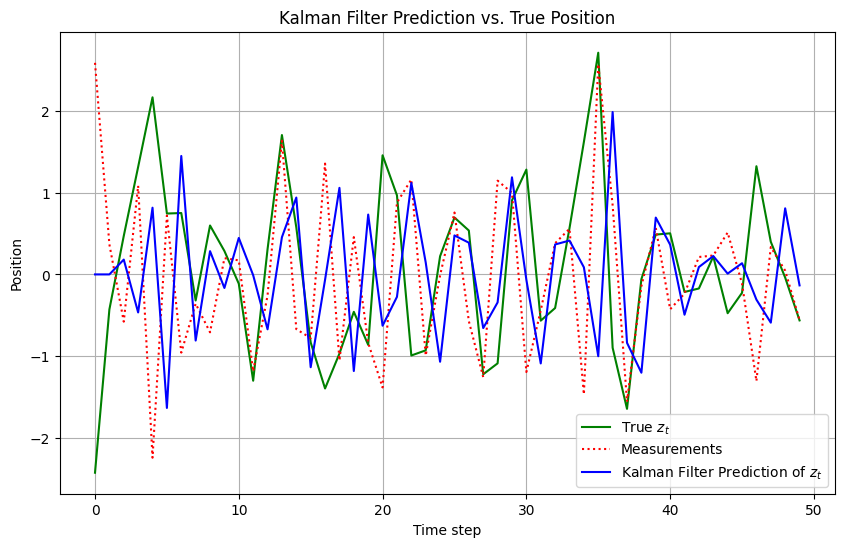

In [72]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(true_position, label='True $z_t$', color='g')
plt.plot(observations, label='Measurements', color='r', linestyle='dotted')
plt.plot(predictions, label='Kalman Filter Prediction of $z_t$', color='b')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.title('Kalman Filter Prediction vs. True Position')
plt.legend()
plt.grid()
plt.show()

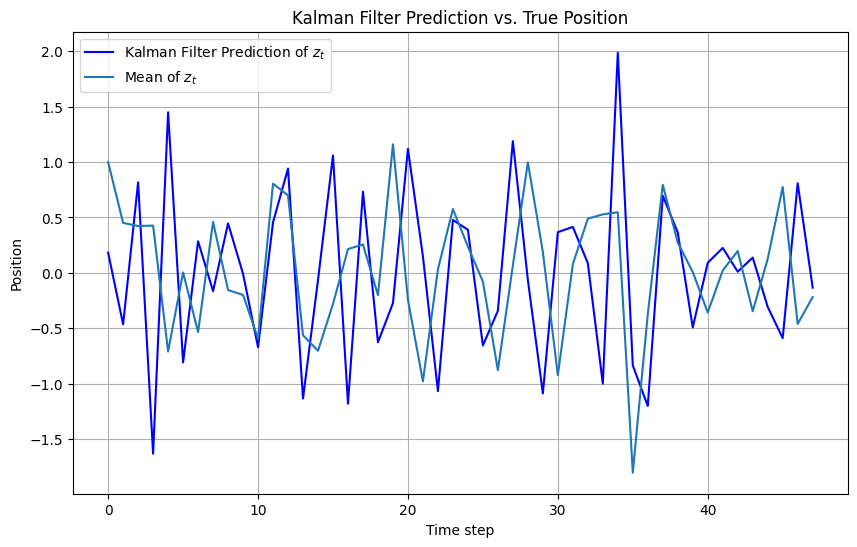

In [73]:
# Plotting the results
plt.figure(figsize=(10, 6))
# plt.plot(true_position, label='True $z_t$', color='g')
# plt.plot(observations, label='Measurements', color='r', linestyle='dotted')
plt.plot(predictions[k:], label='Kalman Filter Prediction of $z_t$', color='b')
means = true_position - ENV.z_noises
plt.plot(means[k:], label='Mean of $z_t$')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.title('Kalman Filter Prediction vs. True Position')
plt.legend()
plt.grid()
plt.show()

## Compare with Other Kalman Filter Code

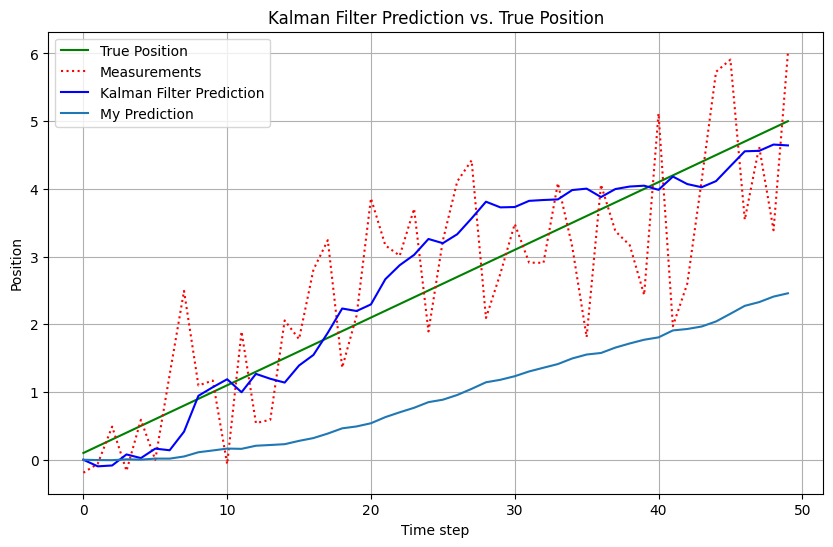

In [89]:
# Parameters
dt = 0.1  # Time step
num_steps = 50  # Number of steps
true_position = np.zeros(num_steps)
observations = np.zeros(num_steps)
predictions = np.zeros(num_steps)
before_update_predictions = np.zeros(num_steps)
my_predictions = np.zeros((num_steps, 2))

# Process and measurement noise
process_variance = 1e-5
measurement_variance = 1

# Initial conditions
position = 0  # Initial true position
velocity = 1  # Initial velocity
predicted_position = 0
predicted_velocity = 0
prediction_error = np.array([[1, 0], [0, 1]])  # Initial uncertainty

# Kalman Filter matrices
F = np.array([[1, dt], [0, 1]])  # State transition model
H = np.array([[1, 0]])  # Measurement model
Q = np.array([[process_variance, 0], [0, process_variance]])  # Process noise covariance
R = np.array([[measurement_variance]])  # Measurement noise covariance

for step in range(num_steps):
    # Simulate true position
    position += velocity * dt
    true_position[step] = position

    # Simulate measurement (with noise)
    observations[step] = position + np.random.normal(0, np.sqrt(measurement_variance))

    # Prediction step
    predicted_position = F[0, 0] * predictions[step - 1] + F[0, 1] * predicted_velocity if step > 0 else 0
    before_update_predictions[step] = predicted_position
    predicted_velocity = F[1, 0] * predictions[step - 1] + F[1, 1] * predicted_velocity if step > 0 else 0

    # Update prediction error
    prediction_error = F @ prediction_error @ F.T + Q

    # Measurement update
    innovation = observations[step] - H @ np.array([[predicted_position], [predicted_velocity]])
    innovation_covariance = H @ prediction_error @ H.T + R

    # Kalman Gain
    kalman_gain = prediction_error @ H.T @ np.linalg.inv(innovation_covariance)

    # Update state
    state_update = np.array([[predicted_position], [predicted_velocity]]) + kalman_gain @ innovation

    # Update predictions
    predictions[step] = state_update[0, 0]
    predicted_velocity = state_update[1, 0]

    # Update prediction error
    prediction_error = (np.eye(2) - kalman_gain @ H) @ prediction_error

    ## STEADY STATE COMPARISON ##
    P = compute_P(F, H, Q, R)
    Kalman_Gain = compute_K(P, H, R)
    last_y = observations[step - 1]
    z_tilde = compute_z_tilde(F, Kalman_Gain, H, my_predictions[step - 1], np.zeros(2), [last_y])
    my_predictions[step] = z_tilde

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(true_position, label='True Position', color='g')
plt.plot(observations, label='Measurements', color='r', linestyle='dotted')
# plt.plot(predictions, label='Kalman Filter Prediction', color='b')
plt.plot(before_update_predictions, label='Kalman Filter Prediction', color='b')
plt.plot(my_predictions[:, 0], label='My Prediction')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.title('Kalman Filter Prediction vs. True Position')
plt.legend()
plt.grid()
plt.show()


## Test Reward Is Reasonable
---
ANNA TODO: this is inprogress

In [ ]:
ENV = Environment(env_params, T=NUM_TIME_STEPS)
np.random.seed(1)
NUM_ACTIONS = 2
T = ENV.get_T()
K = ENV.K
mean_rewards = np.empty((NUM_ACTIONS, T))
# initializing the first K values
for _ in range(K):
    t = ENV.get_t()
    mean_rewards[0][t] = ENV.get_noiseless_reward(0, t)
    mean_rewards[1][t] = ENV.get_noiseless_reward(1, t)
    ENV.increment_t()
while ENV.get_t() < T:
    ### environment ###
    t = ENV.get_t()
    last_vec_z_t = np.flip(np.array(ENV.get_recent_zs()))
    ENV.state_evolution()
    z_t = ENV.get_all_zs()[t]
    ###
    w_t = np.zeros(K)
    w_t[0] = ENV.z_noises[t]
    vec_z_t = Gamma @ last_vec_z_t + w_t
    assert z_t == vec_z_t[0]
    ### produce reward ###
    mean_rewards[0][t] = ENV.get_noiseless_reward(0, t)
    mean_rewards[1][t] = ENV.get_noiseless_reward(1, t)
    ### increment t ###  
    ENV.increment_t()

## Testing Schur-ness
---

In [110]:
for k in range(2, 10):
    gammas = generate_centered_stable_weights(k, 2, 123)
    Gamma = create_Gamma_from_gammas(gammas)
    eigenvalues, eigenvectors = np.linalg.eig(Gamma)
    print(f"k = {k}, max eigenvalue for Gamma: {np.max(eigenvalues)}")
    assert np.max(eigenvalues) < 1

k = 2, max eigenvalue for Gamma: (0.25+0.6614378277661476j)
k = 3, max eigenvalue for Gamma: (0.4785013698899233+0.47753447916701586j)
k = 4, max eigenvalue for Gamma: (0.5509975592891113+0j)
k = 5, max eigenvalue for Gamma: (0.6632336816751925+0.3814973963922387j)
k = 6, max eigenvalue for Gamma: (0.6585382430052464+0.5494767415512358j)
k = 7, max eigenvalue for Gamma: (0.788994826080173+0.33010195522838937j)
k = 8, max eigenvalue for Gamma: (0.7302694715608192+0j)
k = 9, max eigenvalue for Gamma: (0.7758908890184465+0.25659644195109094j)


In [111]:
k = 2
beta_a = 1.0
gammas = generate_centered_stable_weights(k, 2, 123)
Gamma = create_Gamma_from_gammas(gammas)
C = compute_C(k)
W = np.diag(np.zeros(k))
W[0][0] = sigma_z**2
V = np.array([[0.1**2]])
P = compute_P(Gamma, C, W, V)
Kalman_Gain = compute_K(P, C, V)

In [112]:
eigenvalues, eigenvectors = np.linalg.eig(Gamma)
print(f"eigenvalues of Gamma: {eigenvalues}")
print(f"max eigenvalue for Gamma: {np.max(eigenvalues)}")
assert np.abs(np.max(eigenvalues)) < 1

eigenvalues of Gamma: [0.25+0.66143783j 0.25-0.66143783j]
max eigenvalue for Gamma: (0.25+0.6614378277661476j)


In [113]:
def compute_bias_term(k, beta_a, Gamma, K, s, z_s_tilde):
    c_a = compute_c_a(k, beta_a)
    C = compute_C(k)
    A = Gamma - Gamma @ K @ C
    A_s = np.linalg.matrix_power(A, s)

    return c_a @ A_s @ z_s_tilde

In [114]:
for s in range(1, 10):
    bias = compute_bias_term(k, beta_a, Gamma, Kalman_Gain, s, np.ones(k))
    print(f"s: {s}, bias: {bias}")

s: 1, bias: -4.9992189238678986e-05
s: 2, bias: -0.49995000906018383
s: 3, bias: -0.24992501858865082
s: 4, bias: 0.12498750101553037
s: 5, bias: 0.18743127089192949
s: 6, bias: 0.031221886968307425
s: 7, bias: -0.07809219836555986
s: 8, bias: -0.05465079750829199
s: 9, bias: 0.011717576834446533
